We're going to want to do dimension reduction, so let's install UMAP.

In [1]:
!pip install --quiet umap-learn
print('UMAP installed.')

UMAP installed.


Now let's load our data and take a quick look.

In [2]:
import pandas as pd

FISH = '/kaggle/input/fish-species-sampling-weight-and-height-data/fish_data.csv'

df = pd.read_csv(filepath_or_buffer=FISH)
df.head()

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31


Are the classes in our target variable balanced?

In [3]:
from plotly import express

express.histogram(data_frame=df, x='species')

Our classes are mostly balanced; we will want to take this into consideration when we build a model, but it shouldn't have a major impact on our model results.

We really only have two features per species, so let's make a scatter plot.

In [4]:
from plotly import express

express.scatter(data_frame=df, x='length', y='weight', color='species')

Our scatter plot of length vs. weight isolates all of our species except two, which substantially overlap. Let's take another approach, using dimension reduction.

In [5]:
import arrow
from umap import UMAP

time_start = arrow.now()
umap = UMAP(random_state=2024, verbose=False, n_jobs=1, low_memory=False, n_epochs=201)
df[['x', 'y']] = umap.fit_transform(X=df[['length', 'weight', 'w_l_ratio']])
print('done with UMAP in {}'.format(arrow.now() - time_start))

done with UMAP in 0:00:32.019226


In [6]:
express.scatter(data_frame=df, x='x', y='y', color='species')

With the exception of Otolithoides biauritus and Setipinna taty all of our species form tight clusters separate from any other species, so we expect to see a model perform well. Let's build a model.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

COLUMNS = ['length', 'weight', 'w_l_ratio',]

X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df['species'], test_size=0.2, random_state=2024, stratify=df['species'])

logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0)))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0))

model fit in 3200 iterations
accuracy: 0.9265
f1: 0.9262
                        precision    recall  f1-score   support

    Anabas testudineus       0.99      1.00      0.99        95
     Coilia dussumieri       0.99      1.00      0.99        83
Otolithoides biauritus       0.75      0.66      0.70        94
     Otolithoides pama       1.00      0.99      0.99        87
     Pethia conchonius       0.95      1.00      0.97        95
  Polynemus paradiseus       1.00      0.93      0.97        91
  Puntius lateristriga       1.00      1.00      1.00        84
        Setipinna taty       0.70      0.78      0.74        96
 Sillaginopsis panijus       1.00      1.00      1.00        91

              accuracy                           0.93       816
             macro avg       0.93      0.93      0.93       816
          weighted avg       0.93      0.93      0.93       816



Sure enough: our model does very well for all of our classes except two.

Let's take a look at our confusion matrix.

<Axes: >

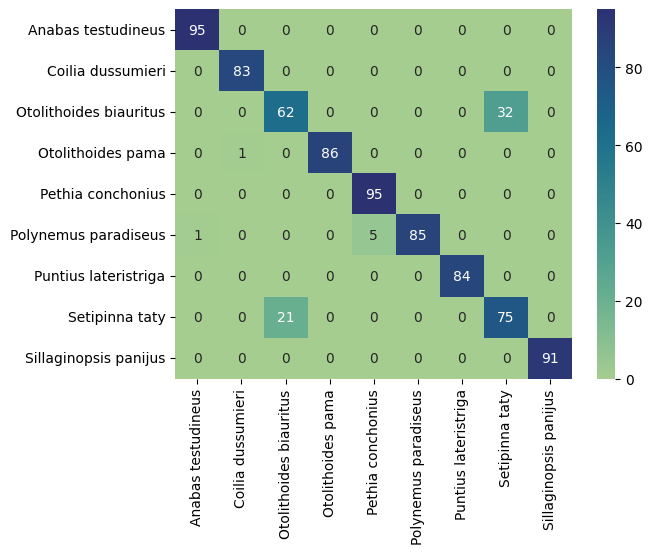

In [8]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(annot=True, cmap='crest', data=pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=logreg.predict(X=X_test), ), index=df['species'].unique(), columns=df['species'].unique()))

Let's go back and ask our model for its probabilities and see if they tell us anything. We want to visualize our data using dimension reduction the way we did above, so we need to use the UMAP model we already fitted, but this time just on the test split of our data.

In [9]:
proba_df = pd.DataFrame(data=logreg.predict_proba(X=X_test).max(axis=1), columns=['probability'])
proba_df['true'] = y_test.tolist()
proba_df['predicted'] = logreg.predict(X=X_test).tolist()
proba_df['correct'] = proba_df['true'] == proba_df['predicted']
proba_df[['x', 'y']] = umap.transform(X=X_test)
proba_df.head()

,probability,true,predicted,correct,x,y
0,0.506231,Otolithoides biauritus,Otolithoides biauritus,True,14.357040,4.033294
1,0.993821,Puntius lateristriga,Puntius lateristriga,True,5.389568,14.080666
2,0.799713,Pethia conchonius,Pethia conchonius,True,4.336019,1.089762
3,0.941756,Anabas testudineus,Anabas testudineus,True,1.305026,9.498668
4,0.993252,Anabas testudineus,Anabas testudineus,True,0.149025,6.337293


What does the mean probability look like?

In [10]:
proba_df[['true', 'probability']].groupby(by='true').mean().sort_values(by='probability').T

true,Otolithoides biauritus,Setipinna taty,Polynemus paradiseus,Otolithoides pama,Pethia conchonius,Puntius lateristriga,Anabas testudineus,Coilia dussumieri,Sillaginopsis panijus
probability,0.606172,0.627071,0.901235,0.93066,0.958944,0.966804,0.968942,0.984034,0.998536


In [11]:
proba_df[['predicted', 'probability']].groupby(by='predicted').mean().sort_values(by='probability').T

predicted,Otolithoides biauritus,Setipinna taty,Polynemus paradiseus,Otolithoides pama,Pethia conchonius,Anabas testudineus,Puntius lateristriga,Coilia dussumieri,Sillaginopsis panijus
probability,0.614212,0.618686,0.930719,0.934155,0.9363,0.962713,0.966804,0.979821,0.998536


Our lower probabilities are concentrated in the classes that are easily confused. 

In [12]:
proba_df[['correct', 'probability']].groupby(by='correct').mean().sort_values(by='probability').T

correct,False,True
probability,0.580766,0.902401


What do the distributions of probabilities look like conditioned on whether the model is correct?

In [13]:
express.histogram(data_frame=proba_df, x='probability', facet_col='correct', log_y=True)

The good news is that our model is never incorrect when it has a high probability; but there are hard cases where it is correct or incorrect with middling probability.

Now we can visualize our data using the model probability; not surprisingly our model has lower-probability predictions for difficult cases. 

In [14]:
express.scatter(data_frame=proba_df, x='x', y='y', color='probability', hover_name='true', hover_data=['predicted'])